# Howto

Original implementation: https://github.com/sveinn-steinarsson/flot-downsample

Downloaded CSV from lttp-numpy repo at https://git.sr.ht/~javiljoen/lttb-numpy/tree/master/item/tests/timeseries.csv (added to this repo as well)

Quickstart:

```shell
poetry install
```

This repo by Charl P. Botha https://charlbotha.com/

## Load data and init

In [17]:
import pandas as pd

df = pd.read_csv("timeseries.csv")
tseries = df.values

x = tseries[:,0]
y = tseries[:,1]

THRESHOLD = 250

## lttbc: C + numpy version by dgoeries

See https://github.com/dgoeries/lttbc

Super neat numpy-API implementation in C

<AxesSubplot: >

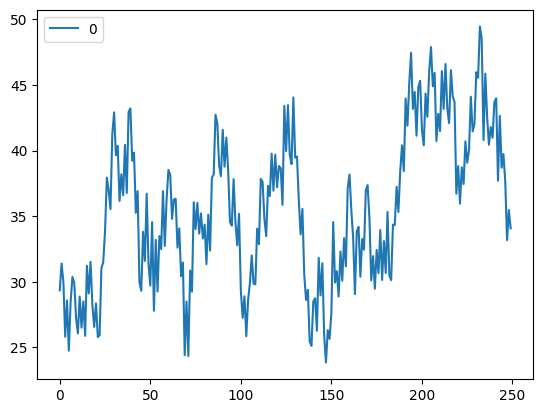

In [3]:
import lttbc

nx, ny = lttbc.downsample(x, y, THRESHOLD)

pd.DataFrame(ny).plot()

In [14]:
%%timeit
down_x, down_y = lttbc.downsample(x, y, THRESHOLD)

10.2 µs ± 32.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## lttb-numpy by javiljoen

See https://git.sr.ht/~javiljoen/lttb-numpy

<AxesSubplot: >

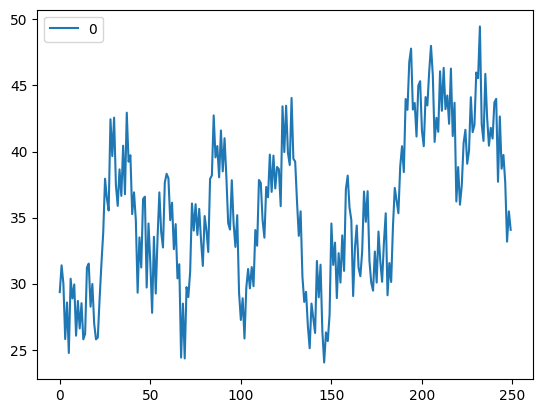

In [38]:
import lttb

# No input validation:
small_data = lttb.downsample(tseries, n_out=THRESHOLD, validators=[])

pd.DataFrame(small_data[:,1]).plot()

In [47]:
%%timeit
lttb.downsample(tseries, n_out=THRESHOLD, validators=[])

3.07 ms ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## pylttb by dexter 2206

<AxesSubplot: >

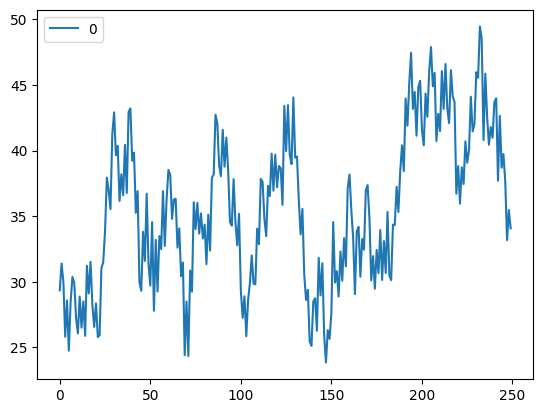

In [42]:
# https://github.com/dexter2206/pylttb
import pylttb

down_x, down_y = pylttb.lttb(x, y, THRESHOLD)

pd.DataFrame(down_y).plot()

In [43]:
%%timeit
pylttb.lttb(x, y, THRESHOLD)

3.64 ms ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Working cython by cpbotha

... but still 30x slower than the pure C version 😭

In [18]:
# ONLY DO THIS CELL IF YOU WANT TO TRY LINE PROFILING (which I could not yet get to work)

# https://gist.github.com/planetceres/333308559e4d908073acb77050812475
#Set compiler directives (cf. http://docs.cython.org/src/reference/compilation.html)
from Cython.Compiler.Options import get_directive_defaults
directive_defaults = get_directive_defaults()

directive_defaults['linetrace'] = True
directive_defaults['binding'] = True

In [10]:
%load_ext Cython


In [27]:
%%cython -a
# use the following magic if you want to try the non-working line profiling
#%%cython -a -f --compile-args=-DCYTHON_TRACE=1

# ARLGH 370us vs 10us for the native version
# - pyx file with setup.py made no difference

# http://docs.cython.org/en/latest/src/userguide/memoryviews.html

import numpy as np
import cython
from cpython cimport array
from libc.math cimport floor, fabs

dtype = np.double

# double aka float64
#ctypedef fused double:
#    double

# https://stackoverflow.com/questions/19537673/slow-division-in-cython
@cython.boundscheck(False)
@cython.wraparound(False)
# disable divide-by-zero checks (only needed at one point) -- does not make a big difference
@cython.cdivision(True)
#@cython.profile(True)
def cy_lttb(double[::1] x, double[::1] y, int threshold = 250):
    cdef Py_ssize_t inp_len = x.shape[0]

    # else:
    #     raise RuntimeError("only support double")

    # equally long vectors
    #assert x.shape[0] == y.shape[0], "vectors should be same length"
    # x.shape is an N-tuple, even when I pass 1D vectors
    # instead we test that x[0] and y[0] are floats
    #assert type(x[0]) is float and type(y[0]) is float

    # allocate output with same type as input
    _x_out = np.zeros((threshold,), dtype=dtype)
    #cdef _x_out = array.array("d")
    #array.resize(_x_out, threshold)
    cdef double[::1] x_out = _x_out

    # allocate output with same type as input
    _y_out = np.zeros((threshold,), dtype=dtype)
    #cdef _y_out = array.array("d")
    #array.resize(_y_out, threshold)
    cdef double[::1] y_out = _y_out

    cdef Py_ssize_t out_idx = 0;
    # should be const
    cdef double every = (inp_len - 2) / float(threshold - 2)

    cdef Py_ssize_t a = 0;
    cdef Py_ssize_t next_a = 0;

    cdef double max_area_point_x = 0.0;
    cdef double max_area_point_y = 0.0;

    # Always add the first point!
    # we don't have the npy_isfinite() check here
    x_out[out_idx] = x[0]
    y_out[out_idx] = y[0]
    out_idx += 1

    cdef double tmp
    cdef double avg_x
    cdef double avg_y
    cdef int i
    cdef Py_ssize_t avg_range_start
    cdef Py_ssize_t avg_range_end
    cdef Py_ssize_t avg_range_length
    cdef Py_ssize_t range_offs
    cdef Py_ssize_t range_to
    cdef double area
    cdef double max_area
    cdef double xa, xdist
    cdef double ya, ydist

    for i in range(threshold - 2):
        avg_x = 0
        avg_y = 0
        avg_range_start = <Py_ssize_t>floor((i + 1) * every) + 1
        avg_range_end = <Py_ssize_t>floor((i + 2) * every) + 1

        if avg_range_end >= threshold:
            avg_range_end = inp_len

        avg_range_length = avg_range_end - avg_range_start

        # for (;avg_range_start < avg_range_end; avg_range_start++){ ...
        while avg_range_start < avg_range_end:
            avg_x += x[avg_range_start]
            avg_y += y[avg_range_start]
            avg_range_start += 1

        # TODO: losing perf here because Py is checking for divide by 0
        avg_x /= avg_range_length
        avg_y /= avg_range_length

        range_offs = <Py_ssize_t>floor((i + 0) * every) + 1;
        range_to = <Py_ssize_t>floor((i + 1) * every) + 1;

        max_area = -1.0
        # bringing out these temp variables for fewer lookups in the area = fabs(...) made almost no diff
        xa = x[a]
        ya = y[a]
        xdist = (xa - avg_x)
        ydist = (avg_y - ya)
        while range_offs < range_to:
            # Calculate triangle area over three buckets
            # TODO: we can drop the 0.5 -- will still choose the greatest area correctly
            area = fabs(xdist * (y[range_offs] - ya) - (xa - x[range_offs]) * ydist) * 0.5
            if area > max_area:
                max_area = area
                max_area_point_x = x[range_offs]
                max_area_point_y = y[range_offs]
                next_a = range_offs

            range_offs += 1

        # the point that gave us max area is the one that is picked from this bucket
        # TODO: if you replace max_area_point_* with <float>i you'll see timeit reporting < 5us instead of 370us
        x_out[out_idx] = max_area_point_x
        y_out[out_idx] = max_area_point_y

        # go to next bucket
        out_idx += 1
        a = next_a;

    # and we add the last point (but here we don't do npy_isfinite())
    x_out[out_idx] = x[inp_len-1]
    y_out[out_idx] = y[inp_len-1]

    # we were working with the views, but we return the nparray
    return _x_out, _y_out

<AxesSubplot: >

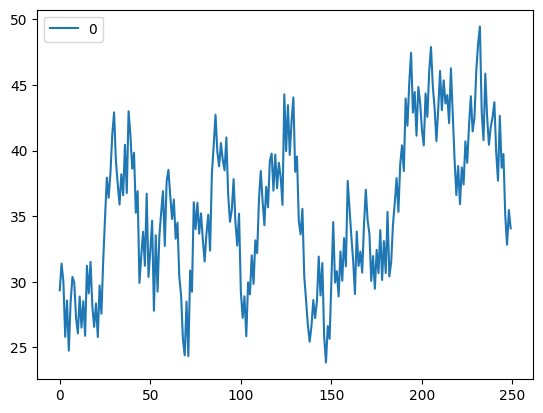

In [28]:
import pandas as pd
down_x, down_y = cy_lttb(x,y,THRESHOLD)
pd.DataFrame(down_y).plot()

In [29]:
%%timeit
cy_lttb(x, y, THRESHOLD)

381 µs ± 1.95 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Continuation of non-working line profiling

In [22]:
#Load Robert Kern's line profiler
%load_ext line_profiler
import line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [24]:
#Print profiling statistics using the `line_profiler` API

profile = line_profiler.LineProfiler(cy_lttb)
profile.runcall(cy_lttb, x, y, THRESHOLD)
profile.print_stats()

Timer unit: 1e-09 s



In [25]:
%lprun -f cy_lttb cy_lttb(x,y,THRESHOLD)

Timer unit: 1e-09 s

## Test the pyx version

see `setup.py`

<AxesSubplot: >

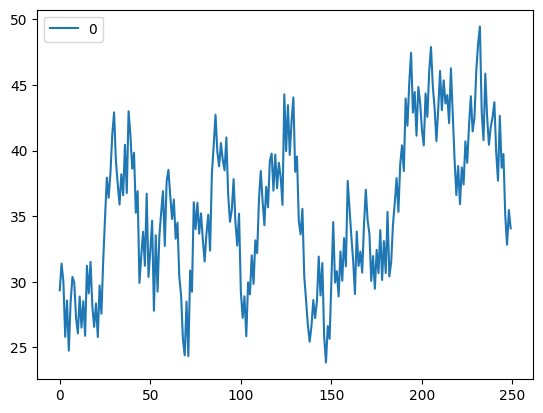

In [4]:
import pandas as pd
import lttbcy
down_x, down_y = lttbcy.downsample(x,y,THRESHOLD)
pd.DataFrame(down_y).plot()

## More failed line profiler attempts, this time for the pyx

Internet says to add this to the top of the pyx file to enable line profiling:

```pyx
# cython: profile=True
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1
```

In [6]:
%load_ext line_profiler
import timeit

def time_lttbcy():
    # extremely sucky -- this just spits out a number, no mention of the units anywhere
    print(timeit.timeit(lambda: lttbcy.downsample(x,y,THRESHOLD), number=1_000))


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [7]:
%lprun -f lttbcy time_lttbcy()

/home/cpbotha/.cache/pypoetry/virtualenvs/lttb-bench-auuxfC1G-py3.10/lib/python3.10/site-packages/line_profiler/ipython_extension.py:71: UserWarning: Could not extract a code object for the object <module 'lttbcy' from '/home/cpbotha/sync/code/mine/sandbox/lttb-bench/lttbcy.cpython-310-x86_64-linux-gnu.so'>
  profile = LineProfiler(*funcs)


28.248389290994965


Timer unit: 1e-09 s